Імпорт бібліотек:

In [116]:
import numpy
import matplotlib
from matplotlib import pyplot
import tensorflow as tf
import cv2
import os
from glob import glob
pyplot.rcParams['figure.figsize'] = [15, 10]

Перелік версій бібліотек, на яких виконано роботу, для вирішень проблем сумісності:

In [2]:
print(f'numpy     : {numpy.__version__}')
print(f'matplotlib: {matplotlib.__version__}')
print(f'tensorflow: {tf.__version__}')
print(f'opencv    : {cv2.__version__}')

numpy     : 1.23.5
matplotlib: 3.7.1
tensorflow: 2.9.1
opencv    : 4.7.0


In [3]:
model: tf.keras.Model = tf.keras.models.load_model('cat_vs_dog_model2', compile=False)
for layer in model.layers:
    layer.treniable = False
model.compile()

In [4]:
def load_image(filename: str):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = img/img.max()
    img = img[:(img.shape[0]//32)*32, :(img.shape[1]//32)*32, :]
    img.shape = (1, img.shape[0], img.shape[1], 3)
    return img

1/1 [==============================] - 3s 3s/step


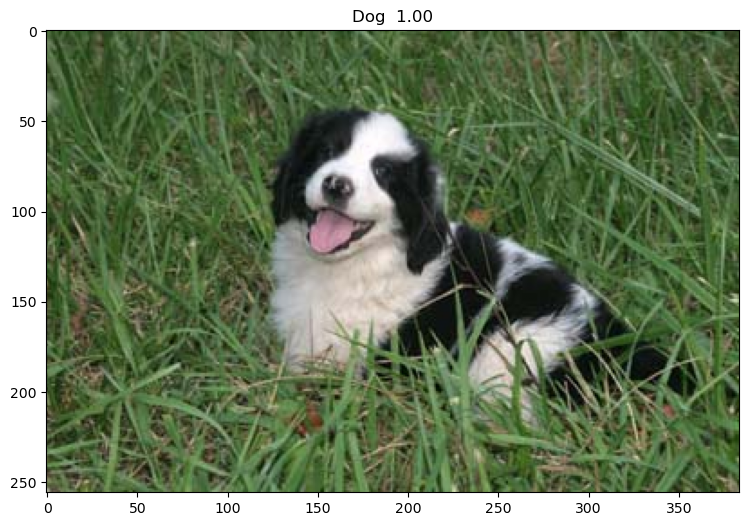

1/1 [==============================] - 0s 483ms/step


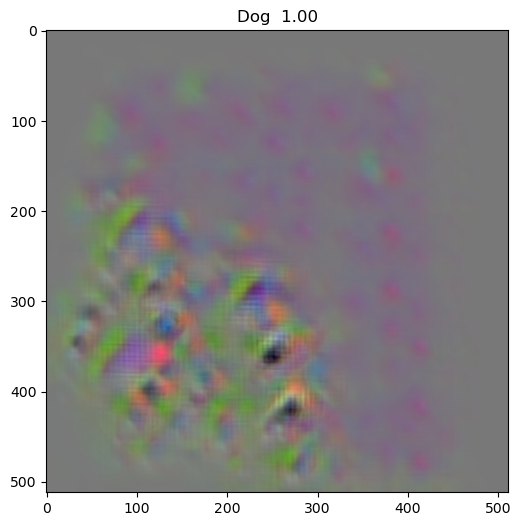

1/1 [==============================] - 0s 273ms/step


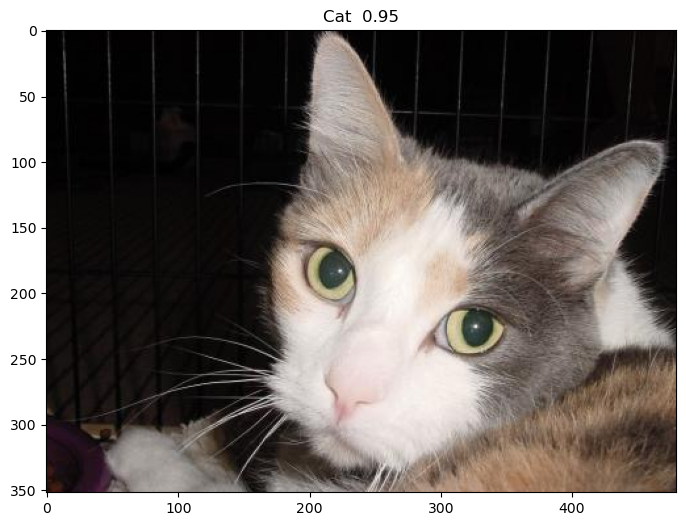

1/1 [==============================] - 0s 251ms/step


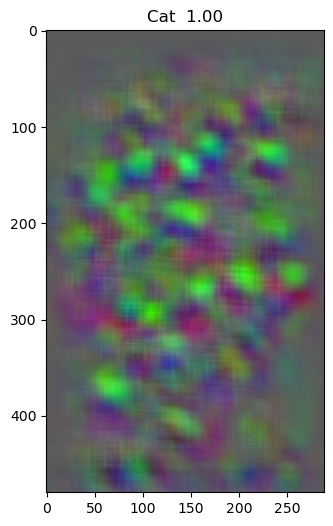

In [5]:
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
images = ['data/PetImages/Dog/12208.jpg', 'ideal_dog.jpg', 'data/PetImages/Cat/12209.jpg', 'ideal_cat.jpg']
for filename in images:
    img = load_image(filename)
    pred = model.predict(img)
    class_name = 'Cat' if pred[0].argmax()==0 else 'Dog'
    propability = pred[0].max()
    pyplot.imshow(img[0])
    pyplot.title(f'{class_name}  {propability:.2f}')
    pyplot.show()

[[0.86487484 0.13512512]]


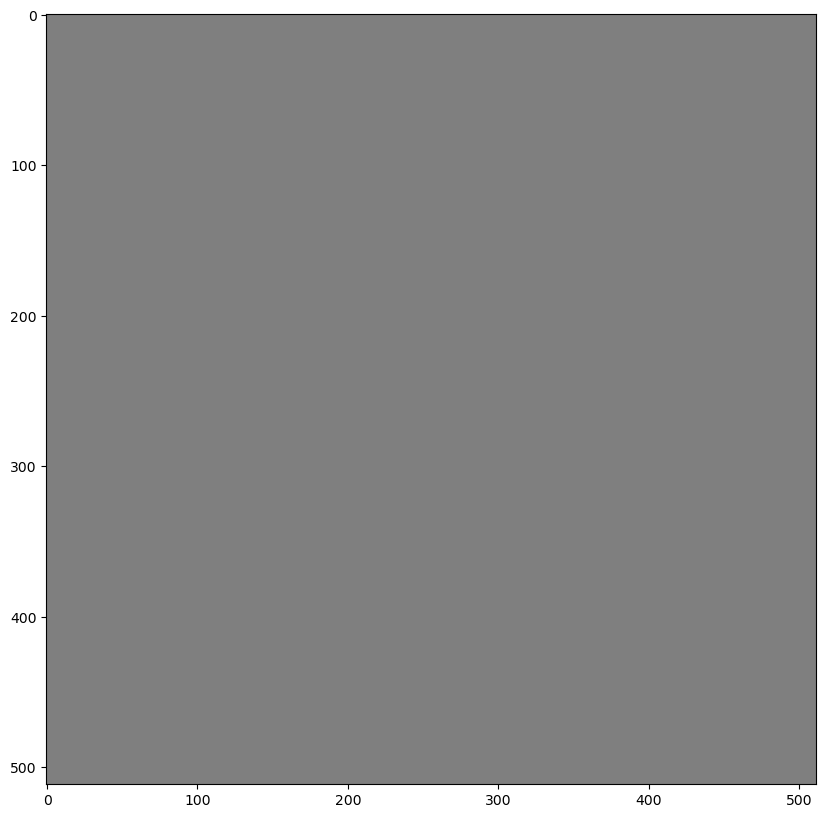

In [120]:
ideal_cat_width = 512
ideal_cat_heght = 512

ideal_cat_width = (ideal_cat_width//32)*32
ideal_cat_heght = (ideal_cat_heght//32)*32
random_init = tf.Variable( tf.random.uniform(shape=(1, ideal_cat_heght, ideal_cat_width, 3), minval=0.4999, maxval=0.50001) ) #, seed=123456

class_of_noise = model(random_init)
ideal_class = tf.constant([[0.0, 1.0]])

print(class_of_noise.numpy())

pyplot.imshow(random_init.numpy()[0])
pyplot.show()

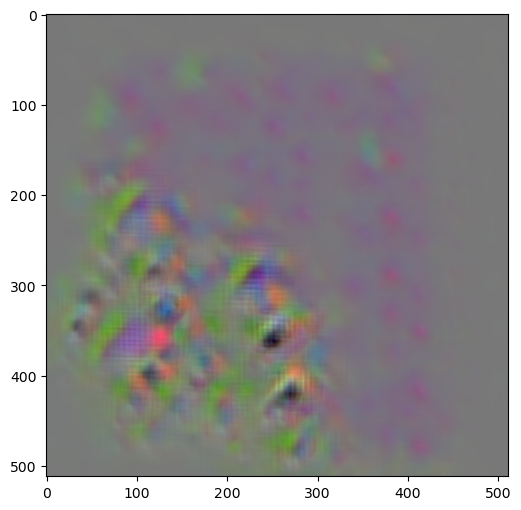

(1, 512, 512, 3)
[0.00102571 0.9989743 ]
Kernel of blur:33. Classification: [0.00102294 0.99897707]
Kernel of blur:21. Classification: [0.00101977 0.9989802 ]
Kernel of blur:13. Classification: [0.00100371 0.9989963 ]
Kernel of blur:7. Classification: [9.567155e-04 9.990433e-01]
Kernel of blur:3. Classification: [8.941602e-04 9.991059e-01]


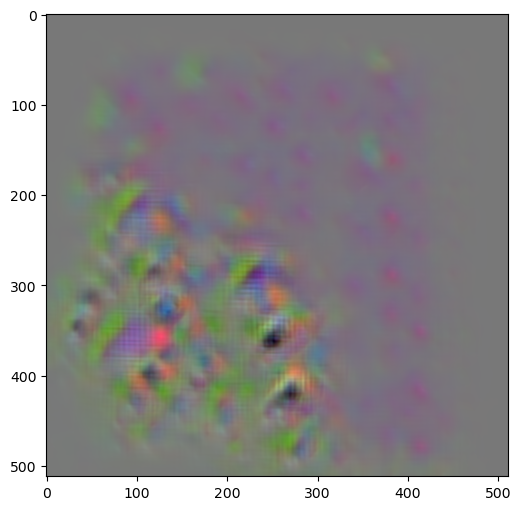

In [82]:
def gaussian_function(radius):
    def calculate(x, y):
        x = (x - radius)/radius
        y = (y - radius)/radius
        return numpy.exp(-(x*x+y*y))/radius
    return calculate

# preor_dog = load_image('data/PetImages/Dog/12209.jpg').astype(dtype=numpy.float32)
# dog_init = tf.Variable( preor_dog )
dog_init = tf.Variable( random_init )
# dog_init = tf.Variable(dog_init)
pyplot.imshow(dog_init.numpy()[0])
pyplot.show()
print(dog_init.shape)
class_of_init = model(dog_init)
print(class_of_init.numpy()[0])

k_size = (dog_init.shape[1]//32)*2 + 1

cv2.imshow('processing', cv2.cvtColor((dog_init.numpy()[0]*255).astype(dtype=numpy.uint8), cv2.COLOR_BGR2RGB))
cv2.waitKey(1)

while k_size>1:
    kernel = numpy.zeros(shape=(k_size, k_size, 3, 3), dtype=numpy.float32)
    gaussian = numpy.fromfunction(gaussian_function(k_size//2), shape=(k_size, k_size), dtype=numpy.float32)
    kernel[:,:,0,0] = gaussian
    kernel[:,:,1,1] = gaussian
    kernel[:,:,2,2] = gaussian
    smoosy = tf.constant(value=kernel, dtype=numpy.float32)
    # train_speed = tf.constant(value=k_size, dtype=numpy.float32)
    for n in range(100):
        with tf.GradientTape() as t:
            f = model(dog_init)
            loss = tf.reduce_mean(tf.square(ideal_class-f))
            gv = t.gradient(loss, dog_init)
        dog_init.assign_sub(tf.nn.conv2d(gv, filters=smoosy, strides=(1,1), padding='SAME')*100.0 )
        dog_init = dog_init - tf.reduce_min(dog_init)
        dog_init = dog_init/tf.reduce_max(dog_init)
        dog_init = tf.Variable(dog_init)
    class_of_init = model(dog_init)
    print(f'Kernel of blur:{k_size}. Classification: {class_of_init.numpy()[0]}')
    cv2.imshow('processing', cv2.cvtColor((dog_init.numpy()[0]*255).astype(dtype=numpy.uint8), cv2.COLOR_BGR2RGB))
    cv2.waitKey(1)
    k_size = ((k_size*2)//6)*2 - 1
dog_init = dog_init - tf.reduce_min(dog_init)
dog_init = dog_init/tf.reduce_max(dog_init)
cv2.destroyAllWindows()
pyplot.imshow(dog_init.numpy()[0])
pyplot.show()

In [83]:
cv2.imwrite('ideal_dog.jpg', cv2.cvtColor((dog_init.numpy()[0]*255).astype(dtype=numpy.uint8), cv2.COLOR_BGR2RGB))

True

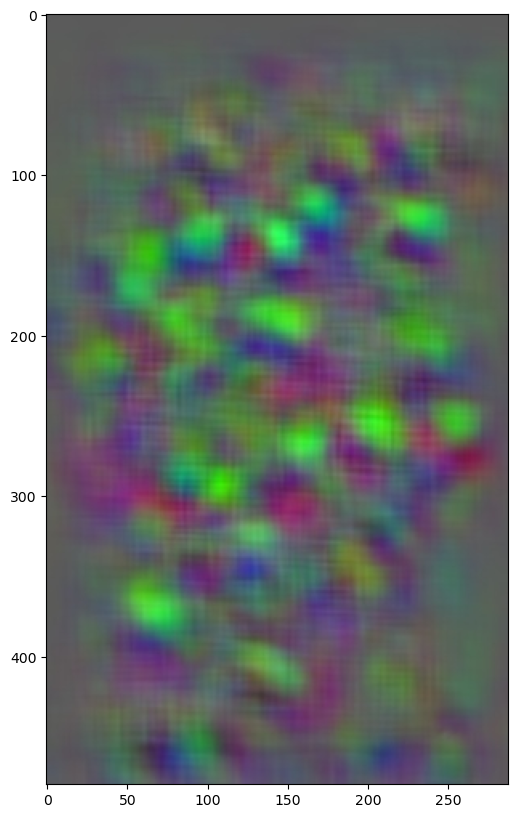

(1, 480, 288, 3)
[0.99876225 0.00123773]
Image size: 480. Classification: [0.9864407  0.01355934]
Image size: 480. Classification: [0.98504436 0.01495562]
Image size: 480. Classification: [0.98495126 0.01504876]
Image size: 480. Classification: [0.9854071  0.01459292]
Image size: 480. Classification: [0.9858517  0.01414829]
Image size: 480. Classification: [0.98680544 0.01319461]
Image size: 480. Classification: [0.9875995  0.01240043]
Image size: 480. Classification: [0.98788315 0.0121168 ]
Image size: 480. Classification: [0.9874923 0.0125077]
Image size: 480. Classification: [0.98763555 0.01236442]
Image size: 480. Classification: [0.9879518  0.01204813]
Image size: 480. Classification: [0.98851424 0.01148572]
Image size: 480. Classification: [0.98896    0.01103998]
Image size: 480. Classification: [0.98906976 0.01093031]
Image size: 480. Classification: [0.989132   0.01086796]
Image size: 480. Classification: [0.9891538  0.01084618]
Image size: 480. Classification: [0.9890534 0.010

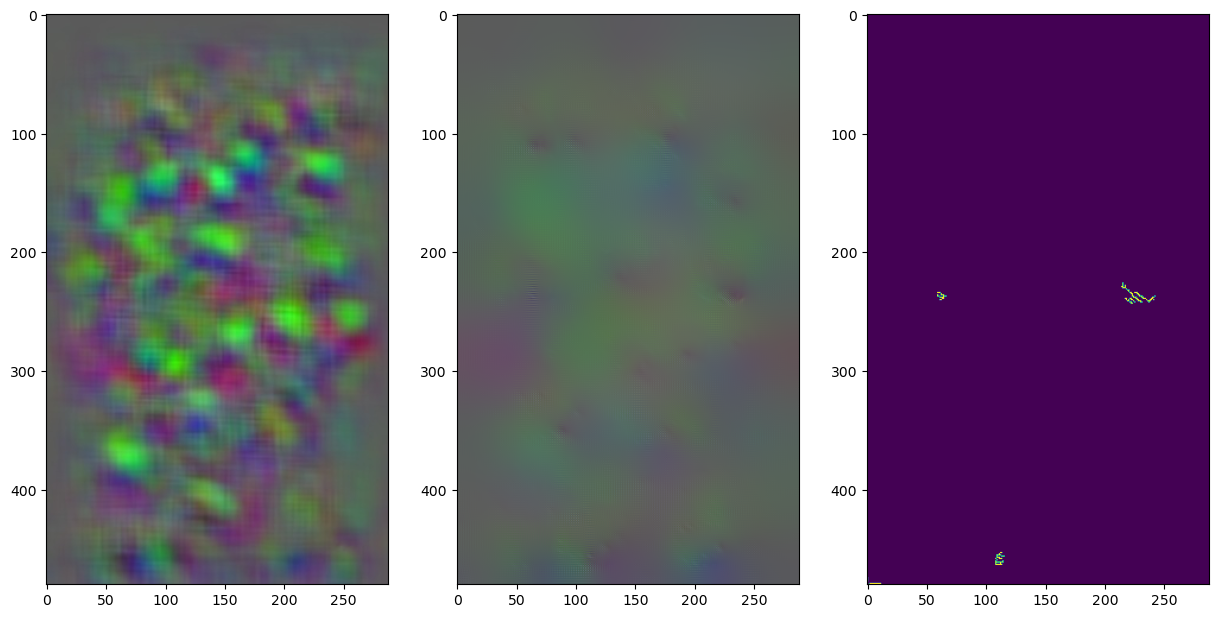

In [121]:
img_size_w = 96
img_size_h = 96

ideal_class = tf.constant(value=[[1.0, 0.0]], dtype=tf.float32)

# random_init = tf.Variable( tf.random.uniform(shape=(1, img_size_h, img_size_w, 3), minval=0.00, maxval=1.00) ) #, seed=123456 data/PetImages/Cat/18.jpg
preor_dog = load_image('ideal_cat.jpg').astype(dtype=numpy.float32)
dog_init = tf.Variable( preor_dog )

# dog_init = tf.Variable( random_init )
pyplot.imshow(dog_init.numpy()[0])
pyplot.show()
class_of_init = model(dog_init)
print(dog_init.shape)
print(class_of_init.numpy()[0])

def make_tf_filter(filter_3x3):
    filter_tf = numpy.zeros(shape=(3, 3, 3, 3), dtype=numpy.float32)
    filter_tf[:, :, 0, 0] = filter_3x3
    filter_tf[:, :, 1, 1] = filter_3x3
    filter_tf[:, :, 2, 2] = filter_3x3
    return tf.constant(value=filter_tf, dtype=tf.float32)

sobel_h = numpy.array([[0.2, 0.6, 0.2],[0.0, 0.0, 0.0],[-0.2,-0.6,-0.2]], dtype=numpy.float32)
sobel_h = make_tf_filter(sobel_h)
sobel_w = numpy.array([[0.2, 0.0,-0.2],[0.6, 0.0,-0.6],[ 0.2, 0.0,-0.2]], dtype=numpy.float32)
sobel_w = make_tf_filter(sobel_w)
s=1
while True:
    for _ in range(50):
        dog_init = tf.Variable(dog_init)
        with tf.GradientTape() as t:
            f = model(dog_init)
            sh = tf.nn.conv2d(dog_init, filters=sobel_h, strides=(1,1), padding='VALID')
            sw = tf.nn.conv2d(dog_init, filters=sobel_w, strides=(1,1), padding='VALID')
            sh = tf.square(sh)
            sw = tf.square(sw)
            sh = tf.reduce_mean(sh)
            sw = tf.reduce_mean(sw)
            loss = tf.reduce_mean(tf.square(ideal_class-f))*20.0 + (sh+sw)*2000.0 #
            gv = t.gradient(loss, dog_init)
            dog_init.assign_sub(gv*7.5)
            # dog_init = dog_init - tf.reduce_min(dog_init)
            # dog_init = dog_init/tf.reduce_max(dog_init)
    if s<20:#dog_init.shape[1]<512:
        s=s+1
        # dog_init = tf.image.resize(dog_init, size=(dog_init.shape[1]+32, dog_init.shape[2]+32))
    else:
        break
    class_of_init = model(dog_init)
    print(f'Image size: {dog_init.shape[1]}. Classification: {class_of_init.numpy()[0]}')
    # print(tf.reduce_max(gv).numpy())
    # if class_of_init.numpy()[0, 0]>0.9:
    #     break
    cv2.imshow('processing', cv2.cvtColor((dog_init.numpy()[0]*255).astype(dtype=numpy.uint8), cv2.COLOR_BGR2RGB))
    cv2.waitKey(1)

cv2.destroyAllWindows()

pyplot.subplot(131)
pyplot.imshow(preor_dog[0])
pyplot.subplot(132)
pyplot.imshow(dog_init.numpy()[0], vmin=0.0, vmax=1.0)
pyplot.subplot(133)
pyplot.imshow(cv2.Canny((dog_init.numpy()[0, :, :, :]*255).astype(numpy.uint8), 10.0, 50.0)) #
pyplot.show()

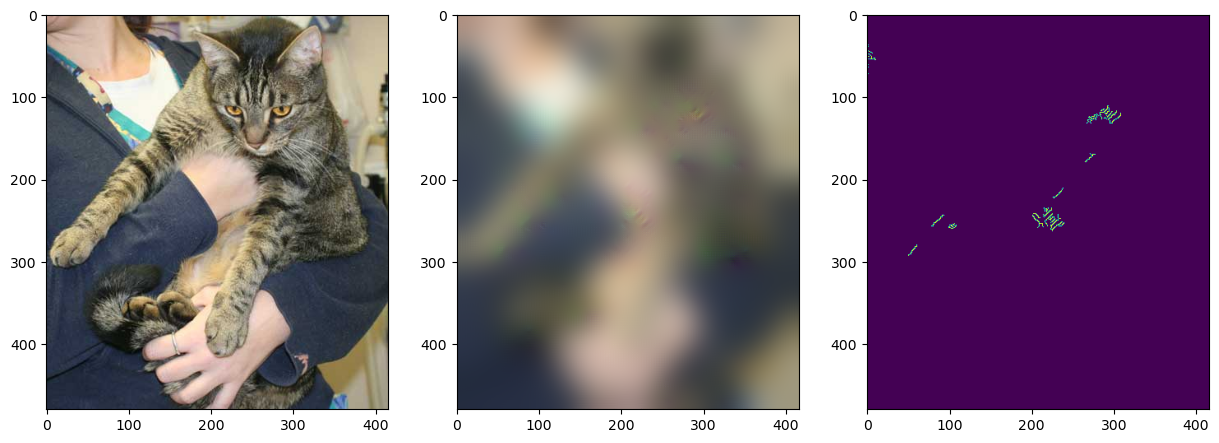

In [117]:
pyplot.subplot(131)
pyplot.imshow(preor_dog[0])
pyplot.subplot(132)
pyplot.imshow(dog_init.numpy()[0], vmin=0.0, vmax=1.0)
pyplot.subplot(133)
pyplot.imshow(cv2.Canny((dog_init.numpy()[0, :, :, :]*255).astype(numpy.uint8), 10.0, 50.0)) #
pyplot.show()
